<a href="https://colab.research.google.com/github/AklimaRimi/online-class/blob/main/notebook/model_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
! git clone https://github.com/AklimaRimi/online-class.git

fatal: destination path 'online-class' already exists and is not an empty directory.


In [32]:
!pip install -q fastbook transformers datasets evaluate ohmeow-blurr

In [33]:
import torch

In [39]:
from fastai import *
from fastbook import *
import pandas as pd
from fastai.text.all import *
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification,AutoConfig
from blurr.text.data.all import *
from blurr.text.modeling.all import *


In [40]:
data = pd.read_csv('/content/online-class/data/datawithSummary (1).csv')
data.tail()

,x,y,summary
642,"Say it's late at night. You're home alone drifting off to sleep. Just entering that dream about fritos and then something is a banging at the door. Suddenly, your wide awake and it feels like your heart's gonna explode. You jump up, ready to run out the back door, possibly grab a Phillips head screwdriver and stab it into the darkness until it sticks into something. Now, whether it's a weeping angel or your neighbor looking to borrow a can of beans, it doesn't really matter because when you heard that sudden noise, your startled brain released an icy typhoon of chemicals. And everything t...",Psychology,"In reality, the moods, ideas, impulses that flash through our minds are spurred by our biological condition . Our brains and our nervous systems in the substance as they produce in our always bathed in, our amazingly complex nuanced systems . One way to understand how your mind works is to look at how the chemistry of your body influences how you think, sense, and feel ."
643,"If someone in a position of authority told you to like stop walking on the grass, you would stop walking on the grass, right? And if they told you to help someone's grandma cross the street or pick up your dog's poop or put your shoes on before you go into a store, you probably comply. But what if they ordered you to physically hurt another person? You're probably thinking, no way, I could never do something like that. But there's a good chance you're wrong. began his work during the widely publicized trial of World War II Nazi War criminal Adolf Eichmann. Eichmann's defense, along with o...",Psychology,"Milgram began his work during the widely publicized trial of World War II Nazi War criminal Adolf Eichmann . His defense, along with other Nazis, for sending millions of people to their deaths, was that he was simply following the orders of his superiors . Milgram recruited 40 male volunteers using newspaper ads . He built a phony shock generator with a scale of 30 switches that could supposedly deliver shocks ."
644,"Here's the riddle in my hobbits, is what's something that we all experience all the time that we can't really measure and barely have words to define. You can't hold it in your hand or take a bite out of it. It isn't something you learn or practice. It just is consciousness. Every science has certain concepts that are so fundamental to get abstract that we have a hard time finding the appropriate words to describe them. Ask a physicist and they'll tell you energy and space defies simple definitions. Biologists know if something is alive but have a harder time explaining what life actually...",Psychology,"Consciousness allows us to contemplate life, think about infinity and ride a unicycle across a tightrope while juggling melons . Our consciousness helps us plan our futures, consider consequences, and reflect on the past . For centuries, scientists learn what they could about the brain solely through clinical observation . With today's technology, we're able to see some of the structures and activity inside a living brain ."
645,"Ever hear a really good joke about polio? Or made a casual reference to someone having hepatitis? Or maybe tease your buddy by saying he has muscular dystrophy. Of course you have never done that, because you are not a terrible person. You'd never make fun of someone for having a physical illness. But folks make all kinds of offhand remarks about people having mental illnesses and never give it a second thought. How often have you heard a person say that someone's psycho or skitso or bipolar OCD? Like a pretty much guarantee that the people who use those terms had no idea what they actual...",Psychology,"As we go deeper into psychological disorders, we get a clearer understanding of their symptoms, types, causes, and perspectives that help explain them . At least the fifth of all people will experience a diagnosable anxiety disorder of some kind at some point in their lives . Obsessive compulsive 

In [41]:
df = Dataset.from_pandas(data)
df

Dataset({
    features: ['x', 'y', 'summary'],
    num_rows: 647
})

In [42]:
len(data['y'].unique())

12

In [43]:
model_cls = AutoModelForSequenceClassification
model_name = "distilroberta-base"

config = AutoConfig.from_pretrained(model_name,num_labels = 12)
config.num_labels = 12

hf_arc,hf_config,hf_tokenizer,hf_model = get_hf_objects(model_name,model_cls=model_cls,config=config)

In [44]:
blocks = (TextBlock(hf_arc,hf_config,hf_tokenizer,hf_model),CategoryBlock)

In [45]:
dblock = DataBlock(blocks = blocks,get_x=ColReader('summary'),get_y=ColReader('y'),splitter=RandomSplitter(valid_pct = .1,seed =42))

In [46]:
dls = dblock.dataloaders(df,bs=16)

In [47]:
model = BaseModelWrapper(hf_model)

In [48]:
learner = Learner(dls,
    model,
    metrics = [accuracy],
    cbs = [BaseModelCallback],
    splitter = blurr_splitter
).to_fp16()


SuggestedLRs(valley=0.0004786300996784121)

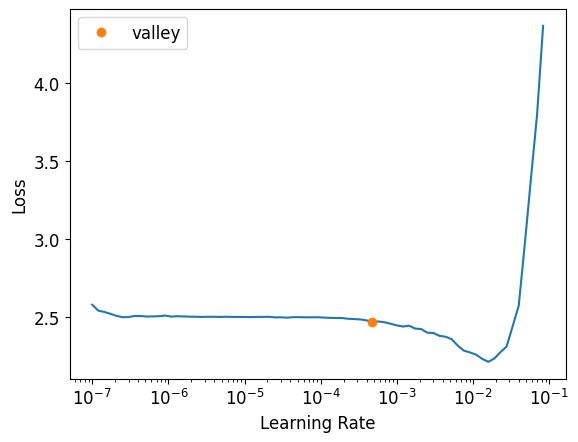

In [49]:
learner.freeze()
learner.lr_find()

In [50]:
learner.fit_one_cycle(5,0.0004786300996784121)

epoch,train_loss,valid_loss,accuracy,time
0,2.427336,2.261836,0.218750,00:03
1,1.665763,0.407126,0.890625,00:04
2,0.929948,0.187610,0.984375,00:02
3,0.569715,0.222889,0.921875,00:02
4,0.384655,0.200751,0.953125,00:02


SuggestedLRs(valley=3.0199516913853586e-05)

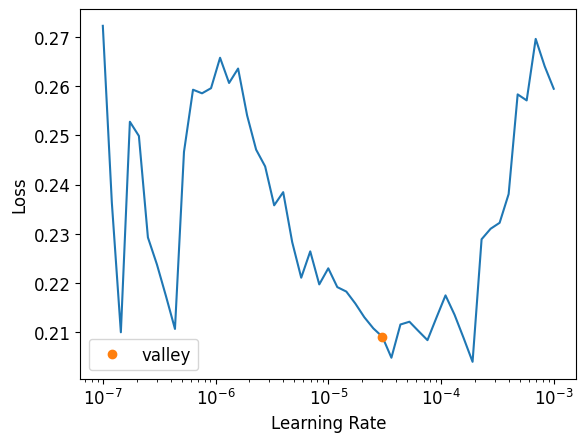

In [51]:
learner.unfreeze()
learner.lr_find()

In [52]:
learner.fit_one_cycle(10,3.0199516913853586e-05)

epoch,train_loss,valid_loss,accuracy,time
0,0.206766,0.164058,0.953125,00:04
1,0.174371,0.124909,0.984375,00:04
2,0.112236,0.153707,0.953125,00:03
3,0.063637,0.126055,0.968750,00:03
4,0.038376,0.128453,0.968750,00:03
5,0.021950,0.130396,0.953125,00:04
6,0.013279,0.134083,0.953125,00:03
7,0.008502,0.130248,0.968750,00:03
8,0.006192,0.133673,0.968750,00:04
9,0.004819,0.133053,0.968750,00:03


In [53]:
learner.export('model1.pkl')

In [54]:
learner.blurr_predict("Nogipson, Tom Cruise and Kanye have all expressed too much emotion in public. Do bodily reactions come as a result of the thought I'm scared, or did my tweaking out body trigger the thought in my brain? These are just some of the questions that we'll be looking at in this messy, exhilarating and terrifying world")

[{'label': 'P',
  'score': 0.9456073045730591,
  'class_index': 10,
  'class_labels': ['Art', 'Astrology', 'Biology', 'Chemistry', 'Economics', 'History', 'Literature', 'Philosophy', 'Physics', 'Politics', 'Psychology', 'Sociology'],
  'probs': [0.007283535785973072,
   0.0020284990314394236,
   0.00208982708863914,
   0.0006364283035509288,
   0.0007982599199749529,
   8.388983405893669e-05,
   0.0025381038431078196,
   0.02827736735343933,
   0.008687506429851055,
   0.0005010039312765002,
   0.9456073045730591,
   0.001468224567361176]}]

In [65]:
! pip install -q onnxruntime onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 82.4 MB/s eta 0:00:00


In [66]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [58]:
model = load_learner('model1.pkl')

In [59]:
classifier = model.model.hf_model.eval()
torch.onnx.export(
    classifier, 
    torch.LongTensor([[0] * 512]),
    'classifier.onnx',
    input_names=['input_ids'],
    output_names=['output'],
    opset_version=14,
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'sequence_len'},
        'output': {0: 'batch_size'}
    }
)

In [67]:
onnx_model_path = 'classifier.onnx'
quantized_onnx_model_path = 'classifier-quantized2.onnx'

quantize_dynamic(
    onnx_model_path,
    quantized_onnx_model_path,
    weight_type=QuantType.QUInt8,
)

Ignore MatMul due to non constant B: /[/roberta/encoder/layer.0/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.0/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.1/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.1/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.2/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.2/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.3/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.3/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.4/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.4/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.5/attention/self/MatMul]
Ignore MatMul due to non constant